# Problem Statement

🎬 **Movie Recommender System**

**Objective**

To improve user engagement on a movie streaming platform by building a personalized recommendation system that suggests movies based on user preferences and similarity patterns.

**Project Overview**

This project is organized into multiple phases, each contributing to the development of an accurate and scalable recommender system.

1. **Data Preparation and Integration**

Datasets Used: User ratings, user information, and movie metadata.

Goal: Clean, merge, and structure the datasets into a unified dataframe suitable for analysis and modeling.

2. **Exploratory Data Analysis (EDA) and Data Cleaning**

Analyze data distribution and structure.

Handle missing values and inconsistencies.

Perform feature engineering, including:

Data type conversions

Extracting attributes such as Release Year from movie titles.

3. **Recommender System Development**
Techniques Implemented

Item-Based Collaborative Filtering:
Recommend movies using Pearson Correlation to identify similar items.

User-Based Collaborative Filtering (Optional):
Identify users with similar rating behavior to generate personalized recommendations.

Cosine Similarity with Nearest Neighbors:
Use cosine distance to find similar movies based on rating vectors.

Matrix Factorization Models:
Implement advanced recommendation techniques using libraries such as cmfrec or Surprise to learn latent user and item representations.

4. **Model Evaluation and Optimization**

Evaluation Metrics:

Root Mean Squared Error (RMSE)

Mean Absolute Percentage Error (MAPE)

Visualization:

Analyze user-user and item-item relationships through embedding-based visualizations.

# Loading Libraries

In [1]:
 pip install cmfrec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.26.post1-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post13-cp312-cp312-linux_x86_64.whl size=5975850 sha256=34c67b684fda35b9f9a62203fc332219feb7d389ba3e59716ed20c36e46c6f92
  Stored in directory: /root/.cache/pip/wheels/46/9d/a7/03614a1633b40dde9aeb6eb12265f9c684feba1e3d82fe05bf
Successfully built cmfrec


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
from cmfrec import CMF
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# New Section

In [3]:
import chardet

with open('zee-users.dat', 'rb') as file:
    raw_data = file.read()
    print(f'Encoding of users file is {chardet.detect(raw_data)}')

with open('zee-movies.dat', 'rb') as file:
    raw_data = file.read()
    print(f'Encoding of movies file is {chardet.detect(raw_data)}')

with open('zee-ratings.dat', 'rb') as file:
    raw_data = file.read(2048)
    print(f'Encoding of ratings file is {chardet.detect(raw_data)}')

Encoding of users file is {'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
Encoding of movies file is {'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}
Encoding of ratings file is {'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


In [4]:
# Read all files into Pandas dataframe format
users, movies, ratings = pd.read_csv('zee-users.dat', delimiter='::'),pd.read_csv('zee-movies.dat', delimiter='::', encoding='ISO-8859-1'),pd.read_csv('zee-ratings.dat', delimiter='::')
movies.rename(columns={'Movie ID':'MovieID'}, inplace=True)

In [5]:
users.head(5)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
movies.head(5)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.head(5)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [9]:
users.describe()

,UserID,Age,Occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


In [10]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Title    3883 non-null   object
 2   Genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [11]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [12]:
ratings.describe()

,UserID,MovieID,Rating,Timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [13]:
age_map = {
    1: "Under 18",
    18: "18-24",
    25: "25-34",
    35: "35-44",
    45: "45-49",
    50: "50-55",
    56: "56+"
}

occupation_map = {
    0:  "other or not specified",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}


In [14]:
users["Age"] = users["Age"].astype("object").map(age_map)
users["Occupation"] = users["Occupation"].map(occupation_map)

users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,K-12 student,48067
1,2,M,56+,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


# EDA, Data Cleaning, and Feature Engineering

## Preparing the dataset

In [15]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
movies['Year'] = movies.Title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies['Year'] = movies.Year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'Title' column
movies["Title"] = movies["Title"].str.replace(r"\(\d{4}\)", "", regex=True)
movies["Title"] = movies["Title"].str.strip()
movies.head(20)

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995
5,6,Heat,Action|Crime|Thriller,1995
6,7,Sabrina,Comedy|Romance,1995
7,8,Tom and Huck,Adventure|Children's,1995
8,9,Sudden Death,Action,1995
9,10,GoldenEye,Action|Adventure|Thriller,1995


In [16]:
dfmov = movies.copy()
dfmov.dropna(inplace=True)
dfmov.Genres = dfmov.Genres.str.split('|')
dfmov.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


## Merge all above dataframes

In [17]:

df_1 = pd.merge(dfmov, ratings, how='inner', on='MovieID')
df_1.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,978237008
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,978233496
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,978225952
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,978226474


In [18]:
data= pd.merge(df_1,users,how= "inner",on = "UserID")
data.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under 18,K-12 student,48067
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,978237008,F,50-55,homemaker,55117
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,978233496,M,25-34,programmer,11413
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,978225952,M,25-34,technician/engineer,61614
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,978226474,F,35-44,academic/educator,95370


### Shape of the dataset

In [19]:
print("No. of rows: ", data.shape[0])
print("No. of columns: ", data.shape[1])

No. of rows:  1000209
No. of columns:  11


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   MovieID     1000209 non-null  int64 
 1   Title       1000209 non-null  object
 2   Genres      1000209 non-null  object
 3   Year        1000209 non-null  object
 4   UserID      1000209 non-null  int64 
 5   Rating      1000209 non-null  int64 
 6   Timestamp   1000209 non-null  int64 
 7   Gender      1000209 non-null  object
 8   Age         1000209 non-null  object
 9   Occupation  1000209 non-null  object
 10  Zip-code    1000209 non-null  object
dtypes: int64(4), object(7)
memory usage: 83.9+ MB


In [21]:
(data.isnull().sum()/len(data))*100

,0
MovieID,0.0
Title,0.0
Genres,0.0
Year,0.0
UserID,0.0
Rating,0.0
Timestamp,0.0
Gender,0.0
Age,0.0
Occupation,0.0


No missing Value observed after joining the datasets

## Feature Engineering

In [22]:
data["Timestamp"]= pd.to_datetime(data['Timestamp'],unit ='s')
data["Year"] = data["Year"].astype("int32")
data["Rating"] = data["Rating"].astype("int32")

In [23]:
bins = [1919,1929, 1939, 1949,1959, 1969, 1979, 1989,2000]
labels = ["20s","30s", "40s", "50s", "60s", "70s", "80","90s"]
data["ReleaseDec"]= pd.cut(data["Year"], bins= bins,labels = labels)
data.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,ReleaseDec
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,2001-01-06 23:37:48,F,Under 18,K-12 student,48067,90s
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,2000-12-31 04:30:08,F,50-55,homemaker,55117,90s
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,2000-12-31 03:31:36,M,25-34,programmer,11413,90s
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,2000-12-31 01:25:52,M,25-34,technician/engineer,61614,90s
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,2000-12-31 01:34:34,F,35-44,academic/educator,95370,90s


## Understanding the Dataset

### Average User Ratings

<Figure size 800x800 with 0 Axes>

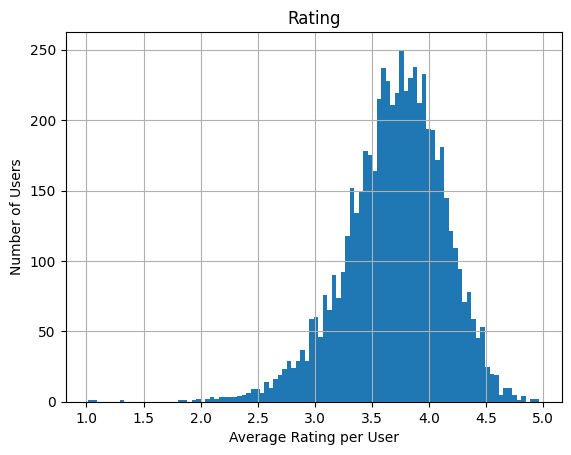

In [24]:
user_ratings = data[["UserID","Rating"]].groupby("UserID").mean()
plt.figure(figsize = (8,8))
user_ratings.hist(bins=100)
plt.xlabel("Average Rating per User")
plt.ylabel("Number of Users")
plt.show()

From above plot, we can see that on average, users are rating movies 3.5-4 more frequently than any other rating.

### No of Movie Released per Year

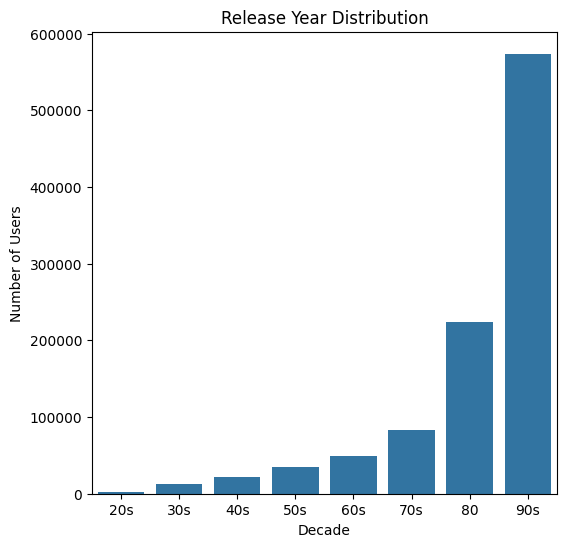

In [25]:
plt.figure(figsize=(6,6))
sns.countplot(x= "ReleaseDec",data = data)
plt.title("Release Year Distribution")
plt.xlabel("Decade")
plt.ylabel("Number of Users")
plt.show()

From the above plot we can infer most of the movies present in the dataset were released in the year 90s.

### Distribution by Age

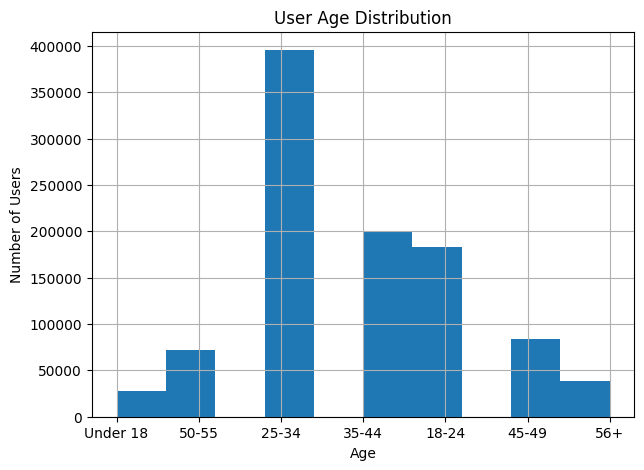

In [26]:
data['Age'].hist(figsize=(7, 5))
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()

From the above plot we can infer that 25-34 age group have watched and rated the most number of movies

### Distribution by Gender -

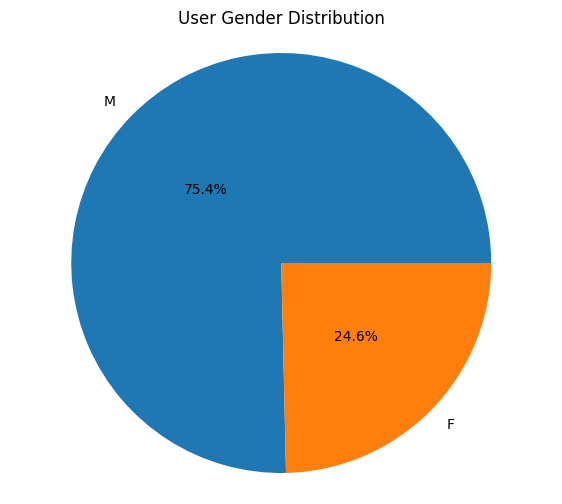

In [27]:
x = data['Gender'].value_counts().values
plt.figure(figsize=(7, 6))
plt.pie(x, center=(0, 0), radius=1.5, labels=['M','F'], autopct='%1.1f%%', pctdistance=0.5)
plt.title('User Gender Distribution')
plt.axis('equal')
plt.show()

From the above plot most of the users in our dataset who’ve rated the movies are **Male**.

### Distribution by Occupation

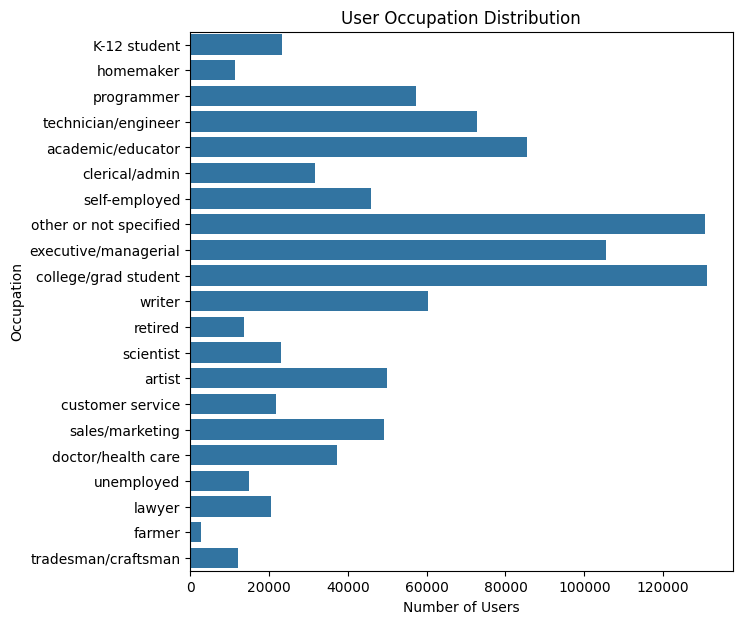

In [28]:
plt.figure(figsize=(7, 7))
sns.countplot(y='Occupation', data=data)
plt.title('User Occupation Distribution')
plt.xlabel('Number of Users')
plt.ylabel('Occupation')
plt.show()

From the above plot users belonging to **college/grad student** profession have watched and rated the most movies.

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   MovieID     1000209 non-null  int64         
 1   Title       1000209 non-null  object        
 2   Genres      1000209 non-null  object        
 3   Year        1000209 non-null  int32         
 4   UserID      1000209 non-null  int64         
 5   Rating      1000209 non-null  int32         
 6   Timestamp   1000209 non-null  datetime64[ns]
 7   Gender      1000209 non-null  object        
 8   Age         1000209 non-null  object        
 9   Occupation  1000209 non-null  object        
 10  Zip-code    1000209 non-null  object        
 11  ReleaseDec  1000164 non-null  category      
dtypes: category(1), datetime64[ns](1), int32(2), int64(2), object(6)
memory usage: 77.3+ MB


Text(0, 0.5, 'Rating count')

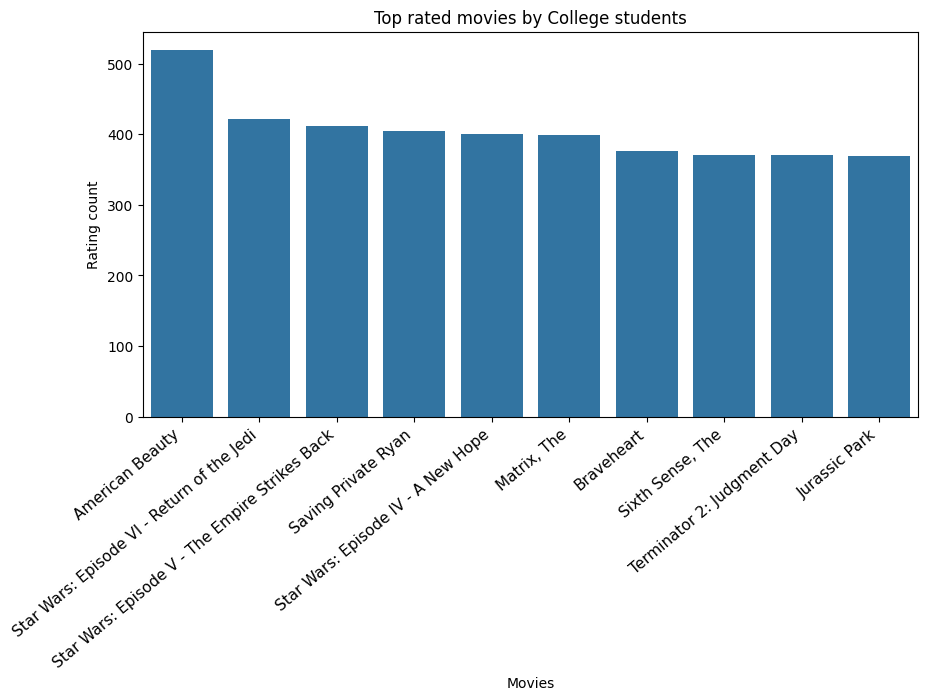

In [30]:
movies_rated_by_college = data[data["Occupation"]=="college/grad student"]
top_10 = movies_rated_by_college[["Title","Rating"]].groupby("Title").agg({"Rating":"count"}).reset_index()
top_10.rename(columns={"Rating": "Rating_count"}, inplace=True)
top_10_movies = top_10.sort_values(by="Rating_count", ascending = False).head(10)
plt.figure(figsize= (10,5))

ax = sns.barplot(data = top_10_movies, x = "Title", y = "Rating_count")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title("Top rated movies by College students")
ax.set_xlabel("Movies")
ax.set_ylabel("Rating count")


From the above plot, the movie with maximum number of ratings is **American Beauty.** for College/grad Students

# Recommendations systems

### User-Interaction Matrix

In [31]:
matrix = pd.pivot_table(data, index='UserID', columns='Title', values='Rating', aggfunc='mean')
matrix.fillna(0, inplace=True) # Imputing 'NaN' values with Zero rating

print(matrix.shape)

matrix.head(10)

(6040, 3664)


Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Checking data sparsity
n_users = data['UserID'].nunique()
n_movies = data['MovieID'].nunique()
sparsity = round(1.0 - data.shape[0] / float( n_users * n_movies), 3)
print('The sparsity level of dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of dataset is 95.5%


## Pearson Correlation


Correlation is a measure that tells how closely two variables move in the same or opposite direction. A positive value indicates that they move in the same direction (i.e. if one increases other increases), where as a negative value indicates the opposite.

The most popular correlation measure for numerical data is Pearson’s Correlation. This measures the degree of linear relationship between two numeric variables and lies between -1 to +1. It is represented by ‘r’.

r=1 means perfect positive correlation

r=-1 means perfect negative correlation

r=0 means no linear correlation (note, it does not mean no correlation)

Item - Based approach

In [33]:
data[data['Title']=='Home Alone']

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,ReleaseDec
156660,586,Home Alone,"[Children's, Comedy]",1990,10,3,2000-12-31 02:12:27,F,35-44,academic/educator,95370,90s
156661,586,Home Alone,"[Children's, Comedy]",1990,11,1,2001-01-07 21:52:36,F,25-34,academic/educator,04093,90s
156662,586,Home Alone,"[Children's, Comedy]",1990,18,4,2000-12-30 05:47:13,F,18-24,clerical/admin,95825,90s
156663,586,Home Alone,"[Children's, Comedy]",1990,22,3,2000-12-30 05:31:07,M,18-24,scientist,53706,90s
156664,586,Home Alone,"[Children's, Comedy]",1990,26,2,2000-12-30 01:34:09,M,25-34,executive/managerial,23112,90s
...,...,...,...,...,...,...,...,...,...,...,...,...
157330,586,Home Alone,"[Children's, Comedy]",1990,5991,3,2001-09-10 03:33:50,F,35-44,writer,94025,90s
157331,586,Home Alone,"[Children's, Comedy]",1990,5996,3,2000-08-14 17:57:25,F,25-34,other or not specified,87114,90s
157332,586,Home Alone,"[Children's, Comedy]",1990,6000,3,2000-04-28 01:18:42,M,45-49,technician/engineer,30075,90s
157333,586,Home Alone,"[Children's, Comedy]",1990,6006,2,2000-04-29 18:37:11,F,Under 18,other or not specified,01036,90s


In [34]:
#movie_name = input("Enter a movie name: ")
movie_name='Home Alone'
movie_rating = matrix[movie_name] # Taking the ratings of that movie
print(movie_rating)

UserID
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
       ... 
6036    0.0
6037    0.0
6038    0.0
6039    0.0
6040    0.0
Name: Home Alone, Length: 6040, dtype: float64


In [35]:
similar_movies = matrix.corrwith(movie_rating) #Finding similar movies

sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True) # Sorting the values based on correlation

sim_df.iloc[1: , :].head() #Top 5 correlated movies.

,Correlation
Title,
Home Alone 2: Lost in New York,0.547203
Mrs. Doubtfire,0.468281
Liar Liar,0.455967
"Mighty Ducks, The",0.446273
Sister Act,0.444612


## Cosine Similarty

The cosine similarity always belongs to the interval [-1,1]. For example, two proportional vectors have a cosine similarity of 1, two orthogonal vectors have a similarity of 0, and two opposite vectors have a similarity of -1.

In [36]:
item_sim = cosine_similarity(matrix.T) #Finding the similarity values between item-item using cosine_similarity
item_sim

array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

### Item-Based Similarity

In [37]:
item_sim_matrix = pd.DataFrame(item_sim, index=matrix.columns, columns=matrix.columns)
item_sim_matrix.head() #Item-similarity Matrix

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


### User-Based Similarity

In [38]:
user_sim = cosine_similarity(matrix) #Finding the similarity values between user-user using cosine_similarity
user_sim

array([[1.        , 0.09638153, 0.12060981, ..., 0.        , 0.17460369,
        0.13359025],
       [0.09638153, 1.        , 0.1514786 , ..., 0.06611767, 0.0664575 ,
        0.21827563],
       [0.12060981, 0.1514786 , 1.        , ..., 0.12023352, 0.09467506,
        0.13314404],
       ...,
       [0.        , 0.06611767, 0.12023352, ..., 1.        , 0.16171426,
        0.09930008],
       [0.17460369, 0.0664575 , 0.09467506, ..., 0.16171426, 1.        ,
        0.22833237],
       [0.13359025, 0.21827563, 0.13314404, ..., 0.09930008, 0.22833237,
        1.        ]])

In [39]:
user_sim_matrix = pd.DataFrame(user_sim, index=matrix.index, columns=matrix.index)
user_sim_matrix.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.096382,0.120610,0.132455,0.090158,0.179222,0.059678,0.138241,0.226148,0.254736,...,0.170588,0.082006,0.090961,0.033663,0.114877,0.186957,0.136233,0.000000,0.174604,0.133590
2,0.096382,1.000000,0.151479,0.171176,0.114394,0.100865,0.305787,0.211120,0.190198,0.227745,...,0.112503,0.091222,0.268565,0.014286,0.183384,0.229011,0.206660,0.066118,0.066457,0.218276
3,0.120610,0.151479,1.000000,0.151227,0.062907,0.074603,0.138332,0.077656,0.126457,0.214487,...,0.092960,0.125864,0.161507,0.000000,0.097308,0.143747,0.107945,0.120234,0.094675,0.133144
4,0.132455,0.171176,0.151227,1.000000,0.045094,0.013529,0.130339,0.100856,0.093651,0.121208,...,0.163629,0.093041,0.382803,0.000000,0.082097,0.171158,0.127703,0.062907,0.064634,0.137968
5,0.090158,0.114394,0.062907,0.045094,1.000000,0.047449,0.126257,0.220817,0.261330,0.117508,...,0.100652,0.035732,0.065278,0.054151,0.179083,0.294354,0.173009,0.020459,0.027689,0.241437


## Nearest Neighbors

In [40]:
model_knn = NearestNeighbors(metric='cosine')
model_knn.fit(matrix.T)

NearestNeighbors(metric='cosine')

In [41]:
##The distances and indices are being calculated with neighbors being 6
distances, indices = model_knn.kneighbors(matrix.T, n_neighbors= 6)

In [42]:
result = pd.DataFrame(indices, columns=['Title1', 'Title2', 'Title3', 'Title4', 'Title5','Title6'])
result.head()
#The result dataframe consits of the different indices of movies based on the distance

,Title1,Title2,Title3,Title4,Title5,Title6
0,0,737,417,287,585,3266
1,1,809,73,2181,3054,3390
2,2,1637,2544,3340,2603,2012
3,3,1467,2183,1318,1054,3533
4,4,26,728,897,496,947


In [43]:
##With this for loop replacing the indices in the result dataframe with movie titles of that corresponding ones
result2 = result.copy()
for i in range(1, 7):
    mov = pd.DataFrame(matrix.T.index).reset_index()
    mov = mov.rename(columns={'index':f'Title{i}'})
    result2 = pd.merge(result2, mov, on=[f'Title{i}'], how='left')
    result2 = result2.drop(f'Title{i}', axis=1)
    result2 = result2.rename(columns={'Title':f'Title{i}'})
result2.head()

,Title1,Title2,Title3,Title4,Title5,Title6
0,"$1,000,000 Duck","Computer Wore Tennis Shoes, The",Blackbeard's Ghost,"Barefoot Executive, The",Candleshoe,That Darn Cat!
1,'Night Mother,"Cry in the Dark, A",Agnes of God,Mommie Dearest,Sophie's Choice,"Trip to Bountiful, The"
2,'Til There Was You,If Lucy Fell,Picture Perfect,To Gillian on Her 37th Birthday,Practical Magic,Mad Love
3,"'burbs, The",Harry and the Hendersons,"Money Pit, The",Ghostbusters II,European Vacation,Weekend at Bernie's
4,...And Justice for All,52 Pick-Up,Coma,Deliverance,"Boys from Brazil, The",Dog Day Afternoon


In [44]:
#movie_name = input("Enter a movie name: ")
movie_name = 'Liar Liar'
result2.loc[result2['Title1']==movie_name] #5 nearest movies for the movie present in Title1.

,Title1,Title2,Title3,Title4,Title5,Title6
1899,Liar Liar,Mrs. Doubtfire,Ace Ventura: Pet Detective,Dumb & Dumber,Home Alone,Wayne's World


## Matrix Factorization

In [45]:
rm = data.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
rm.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Using Cmfrec Library

In [46]:
data.head(5)

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,ReleaseDec
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,2001-01-06 23:37:48,F,Under 18,K-12 student,48067,90s
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,2000-12-31 04:30:08,F,50-55,homemaker,55117,90s
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,2000-12-31 03:31:36,M,25-34,programmer,11413,90s
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,2000-12-31 01:25:52,M,25-34,technician/engineer,61614,90s
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,2000-12-31 01:34:34,F,35-44,academic/educator,95370,90s


##### test train split

In [47]:
df = data.rename(columns={"UserID":"UserId", "MovieID":"ItemId", "Rating":"Rating"})
# drop timestamp (not needed for MF)

# 2. Train / test split in time — as before
df = df.sort_values("Timestamp").reset_index(drop=True)
split_idx = int(0.8 * len(df))
df = df[["UserId","ItemId","Rating"]]
train_df = df.iloc[:split_idx].reset_index(drop=True)
test_df  = df.iloc[split_idx:].reset_index(drop=True)

In [48]:
test_df.shape

(200042, 3)

In [49]:
test_df.head()

,UserId,ItemId,Rating
0,1875,1721,4
1,1875,2621,4
2,635,36,5
3,635,608,5
4,635,2501,4


##### Model Training

In [50]:
model = CMF(method="als",
            k = 4,
            lambda_ = 0.1,
            user_bias = True,
            item_bias = True,
            verbose = True,
            )
model.fit(X = train_df)

Starting ALS optimization routine

Updating B ... done
Updating A ... done
	Completed ALS iteration  1

Updating B ... done
Updating A ... done
	Completed ALS iteration  2

Updating B ... done
Updating A ... done
	Completed ALS iteration  3

Updating B ... done
Updating A ... done
	Completed ALS iteration  4

Updating B ... done
Updating A ... done
	Completed ALS iteration  5

Updating B ... done
Updating A ... done
	Completed ALS iteration  6

Updating B ... done
Updating A ... done
	Completed ALS iteration  7

Updating B ... done
Updating A ... done
	Completed ALS iteration  8

Updating B ... done
Updating A ... done
	Completed ALS iteration  9

Updating B ... done
Updating A ... done
	Completed ALS iteration 10

ALS procedure terminated successfully


Collective matrix factorization model
(explicit-feedback variant)


In [51]:
# 4. Predict on TEST: for each (user, item) pair in test_df
users = test_df["UserId"].values
items = test_df["ItemId"].values
preds = model.predict(user = users, item = items)

In [52]:
model.A_.shape, model.B_.shape

((5400, 4), (3662, 4))

In [53]:
model.A_ # user embeddings

array([[ 0.13450813,  0.3249107 , -0.17981474, -0.03716412],
       [ 0.09203842,  0.10758079,  0.06826771,  0.18073489],
       [ 0.15004788,  0.3335228 ,  0.82954884,  0.36936215],
       ...,
       [ 0.12153762,  0.05888213, -0.08413382,  0.24817999],
       [-0.38733965, -0.19896734,  0.00830029,  0.34980598],
       [ 0.02246242,  0.2385565 ,  0.278172  ,  0.14748448]],
      dtype=float32)

In [54]:
model.B_ # item embeddings

array([[ 0.75059795,  0.0471682 , -2.1012611 , -0.8095042 ],
       [ 0.84264386,  0.49482316, -1.5754989 , -0.23858526],
       [ 0.5597417 , -0.49887136, -1.0296942 , -0.3802253 ],
       ...,
       [ 0.41962934,  0.13284959,  0.5189881 , -0.28215227],
       [-0.03939825,  0.11661904, -0.03847648,  0.01861408],
       [ 0.1779793 , -0.1285859 ,  0.13921604,  0.06019107]],
      dtype=float32)

##### **Evaluating with RMSE and MAPE**

In [55]:
preds = np.clip(preds, 1.0, 5.0)
# (optional) round to 0.5 steps:
preds = np.round(preds * 2) / 2

# Evaluate with RMSE
rmse = np.sqrt(mean_squared_error(test_df["Rating"], preds))
print("CMF Test RMSE:", rmse)




CMF Test RMSE: 0.9741012380005669


In [56]:
# Evaluate with MAPE

# 1. True and predicted ratings
y_true = test_df["Rating"].values
y_pred = preds  # already clipped to [1, 5]

# 2. Avoid division by zero
mask = y_true != 0

# 3. Compute MAPE
mape = np.mean(
    np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])
) * 100

print(f"CMF Test MAPE: {mape:.2f}%")

CMF Test MAPE: 29.12%


In [57]:
user_ids = list(train_df['UserId'].unique())
item_ids = list(train_df['ItemId'].unique())

# A_ is (num_users x k)
# B_ is (num_items x k)

user_embeddings = pd.DataFrame(model.A_, index=user_ids)
item_embeddings = pd.DataFrame(model.B_, index=item_ids)

##### Cosine similarity after CMF : USER -USER

In [58]:
user_sim = cosine_similarity(user_embeddings) #Finding the similarity values between user-user using cosine_similarity
user_sim

array([[ 1.0000001 ,  0.2982742 , -0.08843641, ...,  0.3538621 ,
        -0.59222215,  0.15947084],
       [ 0.2982742 ,  1.0000001 ,  0.73814666, ...,  0.80201375,
         0.05032561,  0.7742805 ],
       [-0.08843641,  0.73814666,  1.0000001 , ...,  0.2070359 ,
         0.02123224,  0.9505329 ],
       ...,
       [ 0.3538621 ,  0.80201375,  0.2070359 , ...,  0.99999976,
         0.16592161,  0.25698924],
       [-0.59222215,  0.05032561,  0.02123224, ...,  0.16592161,
         1.0000001 , -0.01025094],
       [ 0.15947084,  0.7742805 ,  0.9505329 , ...,  0.25698924,
        -0.01025094,  1.0000001 ]], dtype=float32)

In [59]:
user_sim_matrix = pd.DataFrame(user_sim, index=user_embeddings.index, columns=user_embeddings.index)
user_sim_matrix.head()

,6040,6039,6038,6037,6036,6035,6034,6033,6032,6031,...,644,643,642,641,640,639,638,637,636,635
6040,1.000000,0.298274,-0.088436,0.022648,0.632619,0.609929,0.355212,0.003869,0.790065,-0.672674,...,0.186598,0.132506,-0.846365,-0.069418,-0.264169,-0.414061,-0.620162,0.353862,-0.592222,0.159471
6039,0.298274,1.000000,0.738147,0.170032,0.189707,0.189732,-0.365456,0.887015,0.490571,0.169505,...,-0.737831,0.048238,-0.258714,0.489431,-0.537859,0.642177,-0.496320,0.802014,0.050326,0.774280
6038,-0.088436,0.738147,1.000000,-0.236914,-0.349245,0.200357,0.000327,0.725023,0.390433,0.562462,...,-0.602542,-0.377206,0.317159,0.244590,0.029045,0.542612,-0.567121,0.207036,0.021232,0.950533
6037,0.022648,0.170032,-0.236914,1.000000,0.777345,-0.758186,-0.780304,-0.103535,-0.472747,-0.562657,...,-0.606491,0.980831,-0.533197,0.882139,-0.892074,0.548211,0.594569,0.481063,0.772824,-0.098845
6036,0.632619,0.189707,-0.349245,0.777345,1.000000,-0.221818,-0.330522,-0.201888,0.078071,-0.907347,...,-0.250374,0.851412,-0.939125,0.578640,-0.800312,0.069214,0.130597,0.500185,0.211264,-0.083462


##### Cosine similarity after CMF : ITEM -ITEM

In [60]:
item_sim_cmf = cosine_similarity(item_embeddings) #Finding the similarity values between item-item using cosine_similarity
item_sim_cmf

array([[ 0.9999998 ,  0.93731236,  0.9088099 , ..., -0.30926734,
         0.13482867, -0.33735144],
       [ 0.93731236,  1.        ,  0.77987826, ..., -0.24038291,
         0.33126545, -0.29539308],
       [ 0.9088099 ,  0.77987826,  0.9999999 , ..., -0.26398236,
        -0.27532238, -0.00695123],
       ...,
       [-0.30926734, -0.24038291, -0.26398236, ...,  1.        ,
        -0.273571  ,  0.5741413 ],
       [ 0.13482867,  0.33126545, -0.27532238, ..., -0.273571  ,
         1.        , -0.7547144 ],
       [-0.33735144, -0.29539308, -0.00695123, ...,  0.5741413 ,
        -0.7547144 ,  1.0000001 ]], dtype=float32)

In [61]:
item_sim_matrix_cmf = pd.DataFrame(item_sim_cmf, index=item_embeddings.index, columns=item_embeddings.index)
item_sim_matrix_cmf.head() #Item-similarity Matrix

,858,2384,593,2019,1961,213,3505,573,1419,3111,...,3631,1471,2556,792,1714,712,3647,634,3458,545
858,1.000000,0.937312,0.908810,0.882641,0.235986,0.284287,0.057554,0.544881,0.309843,0.337954,...,0.602255,0.175900,0.806095,0.104183,-0.298405,0.343614,-0.109239,-0.309267,0.134829,-0.337351
2384,0.937312,1.000000,0.779878,0.977676,0.421048,0.594342,0.173904,0.671095,0.458877,0.627571,...,0.393641,0.262529,0.713251,0.094292,-0.421164,0.589104,-0.237889,-0.240383,0.331265,-0.295393
593,0.908810,0.779878,1.000000,0.669610,0.380439,0.035156,0.311635,0.654279,-0.061671,0.225086,...,0.705122,-0.071611,0.635334,-0.202269,-0.034631,0.080739,-0.263841,-0.263982,-0.275322,-0.006951
2019,0.882641,0.977676,0.669610,1.000000,0.361146,0.690181,0.058946,0.595047,0.629448,0.664366,...,0.214130,0.217386,0.632287,0.107195,-0.381294,0.586156,-0.271392,-0.093943,0.430678,-0.321270
1961,0.235986,0.421048,0.380439,0.361146,1.000000,0.543386,0.926845,0.942384,-0.178340,0.811757,...,-0.014228,-0.170177,-0.142204,-0.625589,0.024254,0.363903,-0.776113,0.105149,-0.228288,0.628191


### d=2 embedding using CMF

In [62]:
model_2d = CMF(
    method="als",
    k=2,
    lambda_=0.1,
    user_bias=True,
    item_bias=True,
    verbose=False
)

model_2d.fit(X=train_df)

Collective matrix factorization model
(explicit-feedback variant)


In [63]:
# 4. Predict on TEST: for each (user, item) pair in test_df
users = test_df["UserId"].values
items = test_df["ItemId"].values
preds = model_2d.predict(user = users, item = items)

In [64]:
preds = np.clip(preds, 1.0, 5.0)
# (optional) round to 0.5 steps:
preds = np.round(preds * 2) / 2

# Evaluate with RMSE
rmse = np.sqrt(mean_squared_error(test_df["Rating"], preds))
print("CMF Test RMSE:", rmse)

CMF Test RMSE: 0.9636259540429924


In [65]:
model_2d.A_

array([[-0.17576164, -0.31559622],
       [-0.13143043,  0.06428806],
       [-0.46755078,  0.11761209],
       ...,
       [-0.16746914,  0.05427381],
       [ 0.33686504,  0.23174404],
       [-0.06549657,  0.01229249]], dtype=float32)

In [66]:
user_ids = list(train_df['UserId'].unique())
item_ids = list(train_df['ItemId'].unique())

# A_ is (num_users x k)
# B_ is (num_items x k)

In [67]:
user_embeddings_2d = pd.DataFrame(model_2d.A_, index=user_ids)
item_embeddings_2d = pd.DataFrame(model_2d.B_, index=item_ids)

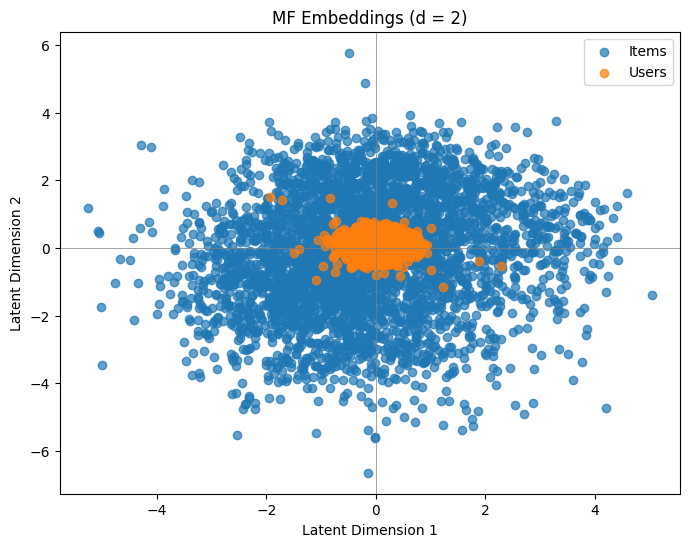

In [68]:
plt.figure(figsize=(8, 6))

# Plot items
plt.scatter(
    item_embeddings_2d.iloc[:, 0],
    item_embeddings_2d.iloc[:, 1],
    alpha=0.7,
    label="Items"
)

# Plot users
plt.scatter(
    user_embeddings_2d.iloc[:, 0],
    user_embeddings_2d.iloc[:, 1],
    alpha=0.7,
    label="Users"
)

plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)

plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("MF Embeddings (d = 2)")
plt.legend()
plt.show()

**Interpretations** :

1: **Users are tightly clustered near the center** (Most users have limited interactions) : Most users have “average” preferences, with only mild deviations captured by latent factors.

2: **Items are much more spread out** (Items receive signals from many users) : Items encode the main structure of the recommendation space; users position themselves relative to items.

3: the Outlier users have strong specific preferences.

4: Items close together → similar audience

5: Outlier items → niche  content

6: **Users are embedded inside the space spanned by items, ensuring predictions interpolate between known item characteristics.**

7: Items form the latent space, and users are embedded within it as regularized preference vectors.

8: The MF embedding plot validates that the model has learned a stable, meaningful latent structure. It helps diagnose underfitting or overfitting, validate similarity quality, and build trust in why certain recommendations are made.



# Questionnaire

1: Users of which age group have watched and rated the most number of movies? **25-34 age group**

2: Users belonging to which profession have watched and rated the most movies? **college/grad student**

3: Most of the users in our dataset who’ve rated the movies are Male. (T/F):- **True**

4: Most of the movies present in our dataset were released in which decade? **90s**

5: The movie with maximum no. of ratings is ___ :- **American Beauty**

6: Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach. :- **Mrs. Doubtfire, Ace Ventura: Pet, Detective Dumb & Dumber**

7: On the basis of approach, Collaborative Filtering methods can be classified into **Memory-based** and **Model-based**.

8 : Pearson Correlation ranges between -1 to 1 whereas, Cosine Similarity belongs to the interval between -1 to 1 in theory, but for non-negative interaction data it lies between 0 and 1.”

9 : Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.:- RMSE:0.97 and MAPE: 0.29


10 : Give the sparse ‘row’ matrix representation for the following dense matrix -

[[1 0]
[3 7]]

In [69]:
from scipy.sparse import csr_matrix

import numpy as np

# create dense matrix
A = np.array([[1,0],[3,7]])
# convert to sparse matrix (CSR method)
S = csr_matrix(A)
print(S)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3 stored elements and shape (2, 2)>
  Coords	Values
  (0, 0)	1
  (1, 0)	3
  (1, 1)	7


## Regression Based Rec Sys

In [70]:
from sklearn.preprocessing import StandardScaler

In [84]:
movies1 = dfmov.copy()

In [85]:
select_movies = ratings.MovieID.value_counts().head(1000).index.to_list()

In [86]:
movies1 = movies1[movies1['MovieID'].isin(select_movies)]
ratings1 = ratings[ratings['MovieID'].isin(select_movies)]

In [87]:
len(movies1)

1000

In [88]:
len(ratings1)

747869

In [89]:
movies1.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
5,6,Heat,"[Action, Crime, Thriller]",1995
6,7,Sabrina,"[Comedy, Romance]",1995


In [90]:
movies2 = movies1.explode('Genres')

In [91]:
movies2

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation,1995
0,1,Toy Story,Children's,1995
0,1,Toy Story,Comedy,1995
1,2,Jumanji,Adventure,1995
1,2,Jumanji,Children's,1995
...,...,...,...,...
3857,3927,Fantastic Voyage,Adventure,1966
3857,3927,Fantastic Voyage,Sci-Fi,1966
3878,3948,Meet the Parents,Comedy,2000
3882,3952,"Contender, The",Drama,2000


In [92]:
movies2 = movies2.pivot(index='MovieID', columns='Genres', values='Title')

In [93]:
movies2.head()

Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,
1,NaN,NaN,Toy Story,Toy Story,Toy Story,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Jumanji,NaN,Jumanji,NaN,NaN,NaN,NaN,Jumanji,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,Grumpier Old Men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grumpier Old Men,NaN,NaN,NaN,NaN
6,Heat,NaN,NaN,NaN,NaN,Heat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heat,NaN,NaN
7,NaN,NaN,NaN,NaN,Sabrina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sabrina,NaN,NaN,NaN,NaN


In [94]:
movies3 = ~movies2.isna()
movies3 = movies3.astype(int)

In [95]:
movies3.head()

Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [99]:
ratings1['Timestamp'] = pd.to_datetime(ratings1['Timestamp'], unit='s')
ratings1['year'] = ratings1['Timestamp'].dt.year
ratings1['month'] = ratings1['Timestamp'].dt.month
ratings1['dayofweek'] = ratings1['Timestamp'].dt.dayofweek
ratings1['hour'] = ratings1['Timestamp'].dt.hour

In [100]:
ratings1.head()

,UserID,MovieID,Rating,Timestamp,timestamp,year,month,dayofweek,hour
0,1,1193,5,2000-12-31 22:12:40,2000-12-31 22:12:40,2000,12,6,22
1,1,661,3,2000-12-31 22:35:09,2000-12-31 22:35:09,2000,12,6,22
2,1,914,3,2000-12-31 22:32:48,2000-12-31 22:32:48,2000,12,6,22
3,1,3408,4,2000-12-31 22:04:35,2000-12-31 22:04:35,2000,12,6,22
4,1,2355,5,2001-01-06 23:38:11,2001-01-06 23:38:11,2001,1,5,23


## Train Test Split

In [101]:
from sklearn.model_selection import train_test_split

ratings1 = ratings1.sort_values("Timestamp")
train_ratings, test_ratings = train_test_split(
    ratings1,
    test_size=0.2,
    shuffle=False  # IMPORTANT: keeps temporal order
)

In [102]:
train_ratings.head()

,UserID,MovieID,Rating,Timestamp,timestamp,year,month,dayofweek,hour
1000138,6040,858,4,2000-04-25 23:05:32,2000-04-25 23:05:32,2000,4,1,23
999873,6040,593,5,2000-04-25 23:05:54,2000-04-25 23:05:54,2000,4,1,23
1000153,6040,2384,4,2000-04-25 23:05:54,2000-04-25 23:05:54,2000,4,1,23
1000192,6040,2019,5,2000-04-25 23:06:17,2000-04-25 23:06:17,2000,4,1,23
1000007,6040,1961,4,2000-04-25 23:06:17,2000-04-25 23:06:17,2000,4,1,23


In [103]:
test_ratings.head()

,UserID,MovieID,Rating,Timestamp,timestamp,year,month,dayofweek,hour
103476,687,3505,5,2000-12-01 17:12:45,2000-12-01 17:12:45,2000,12,4,17
109525,714,1240,5,2000-12-01 17:12:46,2000-12-01 17:12:46,2000,12,4,17
99177,660,708,3,2000-12-01 17:12:50,2000-12-01 17:12:50,2000,12,4,17
98881,660,852,4,2000-12-01 17:12:50,2000-12-01 17:12:50,2000,12,4,17
98776,660,468,3,2000-12-01 17:12:50,2000-12-01 17:12:50,2000,12,4,17


## Feature Engineering

In [105]:
user_agg_features = train_ratings.groupby('UserID').agg(
    user_mean_rating = ('Rating', 'mean'),
    user_median_rating = ('Rating', 'median'),
    user_rating_std = ('Rating', 'std'),
    user_rating_count = ('Rating', 'count'),
    user_min_rating=('Rating', 'min'),
    user_max_rating=('Rating', 'max')
).reset_index()

In [106]:
user_agg_features

,UserID,user_mean_rating,user_median_rating,user_rating_std,user_rating_count,user_min_rating,user_max_rating
0,659,3.660714,4.0,0.837242,56,2,5
1,660,3.278195,3.0,0.956266,133,1,5
2,661,4.816327,5.0,0.486204,49,3,5
3,662,3.255319,3.0,0.960915,94,1,5
4,663,3.641304,4.0,0.932697,92,2,5
...,...,...,...,...,...,...,...
5371,6036,3.370577,3.0,1.059124,537,1,5
5372,6037,3.806061,4.0,0.861769,165,1,5
5373,6038,3.823529,4.0,1.185079,17,1,5
5374,6039,3.921348,4.0,0.772021,89,2,5


In [108]:
user_time_based_feats = train_ratings.groupby('UserID').agg(
    avg_time_gap_user=('Timestamp', lambda x: x.sort_values().diff().dt.total_seconds().mean()),
    ratings_per_month_user=('month', lambda x: len(x) / ratings1['month'].nunique())
).reset_index()

In [109]:
user_time_based_feats

,UserID,avg_time_gap_user,ratings_per_month_user
0,659,23.781818,4.666667
1,660,27.242424,11.083333
2,661,19.958333,4.083333
3,662,41.838710,7.833333
4,663,75.890110,7.666667
...,...,...,...
5371,6036,85.535448,44.750000
5372,6037,566.115854,13.750000
5373,6038,648.562500,1.416667
5374,6039,600.806818,7.416667


In [111]:
train_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 598295 entries, 1000138 to 103369
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   UserID     598295 non-null  int64         
 1   MovieID    598295 non-null  int64         
 2   Rating     598295 non-null  int64         
 3   Timestamp  598295 non-null  datetime64[ns]
 4   timestamp  598295 non-null  datetime64[ns]
 5   year       598295 non-null  int32         
 6   month      598295 non-null  int32         
 7   dayofweek  598295 non-null  int32         
 8   hour       598295 non-null  int32         
dtypes: datetime64[ns](2), int32(4), int64(3)
memory usage: 36.5 MB


In [112]:
movie_agg_features = train_ratings.groupby('MovieID').agg(
    movie_mean_rating=('Rating', 'mean'),
    movie_median_rating=('Rating', 'median'),
    movie_rating_std=('Rating', 'std'),
    movie_rating_count=('Rating', 'count'),
    movie_min_rating=('Rating', 'min'),
    movie_max_rating=('Rating', 'max')
).reset_index()
movie_agg_features['movie_rating_std'] = movie_agg_features['movie_rating_std'].fillna(0)

In [113]:
movie_agg_features

,MovieID,movie_mean_rating,movie_median_rating,movie_rating_std,movie_rating_count,movie_min_rating,movie_max_rating
0,1,4.147211,4.0,0.857618,1739,1,5
1,2,3.193606,3.0,0.978321,563,1,5
2,3,3.010554,3.0,1.076391,379,1,5
3,6,3.874198,4.0,0.927772,779,1,5
4,7,3.427350,3.0,1.005552,351,1,5
...,...,...,...,...,...,...,...
995,3911,4.166667,4.0,0.841377,300,1,5
996,3916,3.919283,4.0,1.103939,223,1,5
997,3927,3.590406,4.0,0.824475,271,1,5
998,3948,3.721973,4.0,1.018398,446,1,5


In [114]:
movie_time_based_feats = train_ratings.groupby('MovieID').agg(
    rating_span_days_movie=('Timestamp', lambda x: (x.max() - x.min()).days + 1),
    avg_time_gap_movie=('Timestamp', lambda x: x.sort_values().diff().dt.total_seconds().mean()),
    rating_frequency_movie=('MovieID', 'count')
).reset_index()

In [115]:
movie_time_based_feats

,MovieID,rating_span_days_movie,avg_time_gap_movie,rating_frequency_movie
0,1,220,10919.115075,1739
1,2,220,33706.268683,563
2,3,220,50097.637566,379
3,6,220,24383.191517,779
4,7,220,54217.042857,351
...,...,...,...,...
995,3911,60,17333.187291,300
996,3916,66,25440.355856,223
997,3927,73,23344.729630,271
998,3948,55,10524.253933,446


In [117]:
train_df = train_ratings[['UserID','MovieID','Rating']].copy()

### Adding the features to the Train and test dataset

In [118]:
train_df = train_df.merge(user_agg_features,on='UserID',how='left')
train_df = train_df.merge(user_time_based_feats,on='UserID',how='left')
train_df = train_df.merge(movie_agg_features,on='MovieID',how='left')
train_df = train_df.merge(movie_time_based_feats,on='MovieID',how='left')
train_df = train_df.merge(movies3,on='MovieID',how='left')

In [119]:
test_df = test_ratings[['UserID','MovieID','Rating']].copy()
test_df = test_df.merge(movies3,on='MovieID',how='left')
test_df = test_df.merge(user_agg_features,on='UserID',how='left')
test_df = test_df.merge(user_time_based_feats,on='UserID',how='left')
test_df = test_df.merge(movie_agg_features,on='MovieID',how='left')
test_df = test_df.merge(movie_time_based_feats,on='MovieID',how='left')

In [120]:
train_df

,UserID,MovieID,Rating,user_mean_rating,user_median_rating,user_rating_std,user_rating_count,user_min_rating,user_max_rating,avg_time_gap_user,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,6040,858,4,3.541126,4.0,1.125513,231,1,5,35325.947826,...,0,0,0,0,0,0,0,0,0,0
1,6040,593,5,3.541126,4.0,1.125513,231,1,5,35325.947826,...,0,0,0,0,0,0,0,1,0,0
2,6040,2384,4,3.541126,4.0,1.125513,231,1,5,35325.947826,...,0,0,0,0,0,0,0,0,0,0
3,6040,2019,5,3.541126,4.0,1.125513,231,1,5,35325.947826,...,0,0,0,0,0,0,0,0,0,0
4,6040,1961,4,3.541126,4.0,1.125513,231,1,5,35325.947826,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598290,659,3147,5,3.660714,4.0,0.837242,56,2,5,23.781818,...,0,0,0,0,0,0,0,1,0,0
598291,659,150,3,3.660714,4.0,0.837242,56,2,5,23.781818,...,0,0,0,0,0,0,0,0,0,0
598292,714,1036,5,4.312500,4.0,0.744343,208,2,5,756.966184,...,0,0,0,0,0,0,0,1,0,0
598293,714,1200,5,4.312500,4.0,0.744343,208,2,5,756.966184,...,0,0,0,0,0,0,1,1,1,0


In [121]:
test_df

,UserID,MovieID,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,ratings_per_month_user,movie_mean_rating,movie_median_rating,movie_rating_std,movie_rating_count,movie_min_rating,movie_max_rating,rating_span_days_movie,avg_time_gap_movie,rating_frequency_movie
0,687,3505,5,0,0,0,0,0,0,0,...,11.666667,3.841727,4.0,0.872847,278,1,5,220,68369.613718,278
1,714,1240,5,1,0,0,0,0,0,0,...,17.333333,4.153934,4.0,0.853982,1754,1,5,220,10826.794067,1754
2,660,708,3,0,0,0,0,1,0,0,...,11.083333,3.451429,3.0,0.914275,525,1,5,220,36133.727099,525
3,660,852,4,0,0,0,0,1,0,0,...,11.083333,3.230924,3.0,0.934950,498,1,5,219,38064.816901,498
4,660,468,3,0,0,0,0,1,0,0,...,11.083333,3.240741,3.0,0.958918,270,1,5,219,70174.204461,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149569,5948,3098,4,0,0,0,0,0,0,0,...,16.500000,3.807018,4.0,0.874169,399,1,5,220,47680.854271,399
149570,5312,3267,4,1,0,0,0,0,0,0,...,37.416667,3.645995,4.0,0.952908,387,1,5,219,49016.997409,387
149571,4958,3489,4,0,1,0,0,0,0,0,...,16.000000,3.034305,3.0,1.078782,583,1,5,220,32547.831615,583
149572,4958,1407,5,0,0,0,0,0,0,0,...,16.000000,3.587432,4.0,1.039181,732,1,5,220,25953.224350,732


In [122]:
test_df = test_df[train_df.columns]

In [123]:
train_movies = train_df.pop('MovieID')
train_users = train_df.pop('UserID')
test_movies = test_df.pop('MovieID')
test_users = test_df.pop('UserID')

In [124]:
set(train_df.columns)-set(test_df.columns)

set()

In [125]:
y_train = train_df.pop('Rating')
y_test = test_df.pop('Rating')

In [130]:
y_train

,Rating
0,4
1,5
2,4
3,5
4,4
...,...
598290,5
598291,3
598292,5
598293,5


In [126]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# ------------------------
# Build Model
# ------------------------
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# ------------------------
# Train
# ------------------------
model.fit(train_df, y_train)

# ------------------------
# Predict & Evaluate
# ------------------------
preds = model.predict(test_df)

# Round to nearest 0.5
preds = np.round(preds * 2) / 2

# Clip to valid range
preds = np.clip(preds, 0.5, 5.0)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("Test RMSE:", rmse)

Test RMSE: 1.0535276463904422


In [131]:
y_test.unique()

array([5, 3, 4, 2, 1])

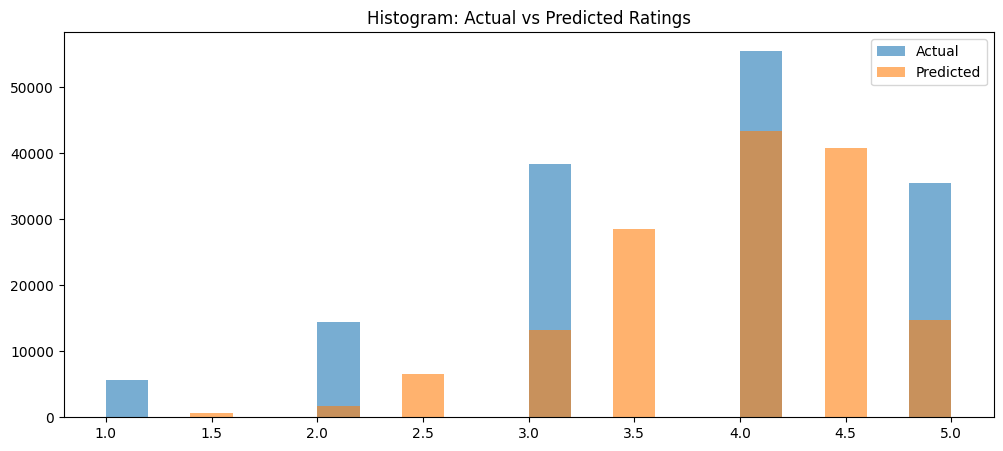

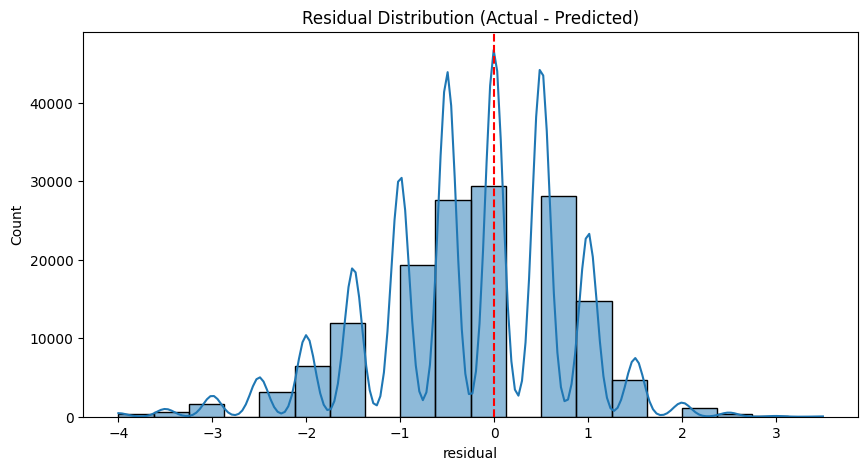


Summary Statistics:
              actual      predicted       residual
count  149574.000000  149574.000000  149574.000000
mean        3.675986       3.951325      -0.275339
std         1.054228       0.688529       1.016915
min         1.000000       1.000000      -4.000000
25%         3.000000       3.500000      -1.000000
50%         4.000000       4.000000       0.000000
75%         4.000000       4.500000       0.500000
max         5.000000       5.000000       3.500000

Residual Mean: -0.275338628371241
Residual Std: 1.016914972376907


In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
analysis_df = pd.DataFrame({
    "actual": y_test,
    "predicted": preds
})


# -----------------------------
# 2. Histogram Comparison
# -----------------------------
plt.figure(figsize=(12,5))
plt.hist(analysis_df["actual"], bins=20, alpha=0.6, label="Actual")
plt.hist(analysis_df["predicted"], bins=20, alpha=0.6, label="Predicted")
plt.title("Histogram: Actual vs Predicted Ratings")
plt.legend()
plt.show()

# -----------------------------
# 4. Residuals Distribution
# -----------------------------
analysis_df["residual"] = analysis_df["actual"] - analysis_df["predicted"]

plt.figure(figsize=(10,5))
sns.histplot(analysis_df["residual"], bins=20, kde=True)
plt.title("Residual Distribution (Actual - Predicted)")
plt.axvline(0, color='red', linestyle='--')
plt.show()


# -----------------------------
# 5. Summary Statistics
# -----------------------------
print("\nSummary Statistics:")
print(analysis_df.describe())

print("\nResidual Mean:", analysis_df["residual"].mean())
print("Residual Std:", analysis_df["residual"].std())

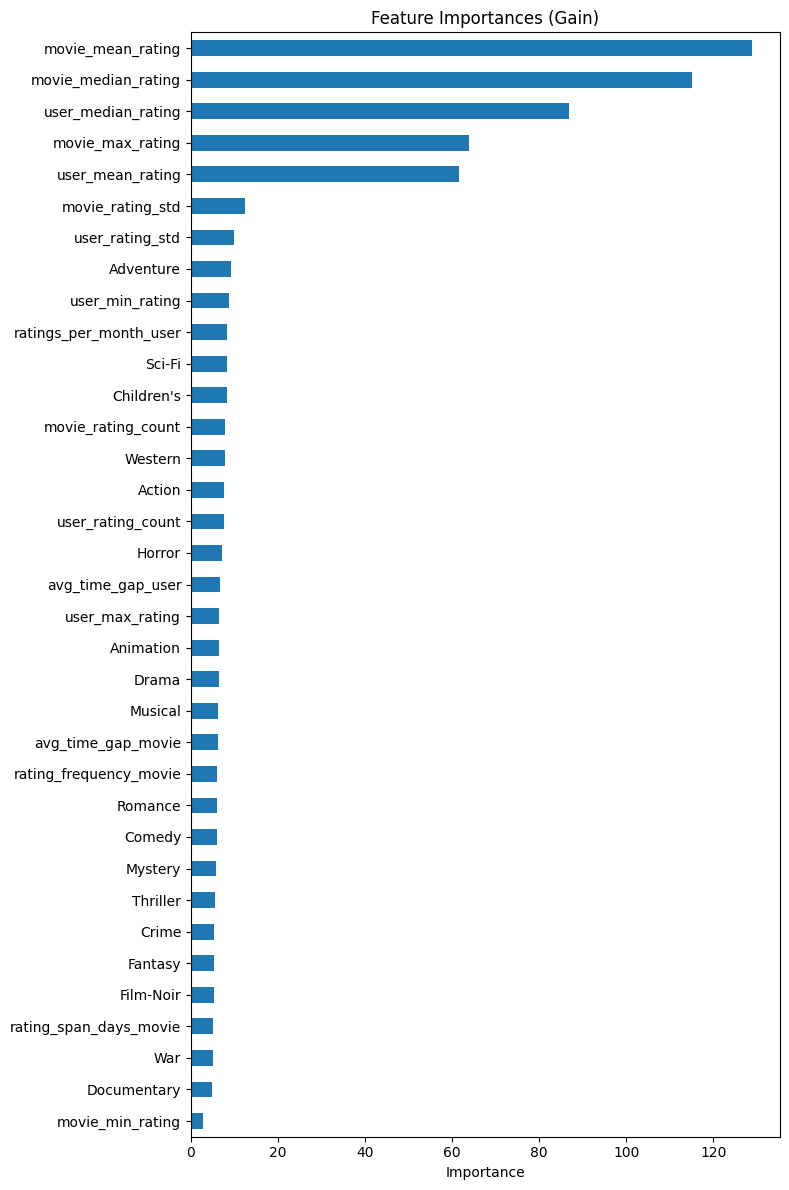

In [133]:
raw_importances = model.get_booster().get_score(importance_type="gain")

fi = (
    pd.Series(raw_importances)
      .sort_values(ascending=False)
)

plt.figure(figsize=(8, 12))
fi.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Feature Importances (Gain)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()